In [352]:
import torch# type: ignore
import torch.nn as nn # type: ignore
import torch.nn.functional as F# type: ignore
import torch.optim as optim# type: ignore
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [353]:
# 导入数据
file_path = r"C:\Users\79365\Desktop\图像-叶绿素\叶绿素\matlab数据\280数据\280.mat"
data = sio.loadmat(file_path)
# 提取X和Y
X = data['X']
Y = data['Y'] 

In [354]:
# 使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [355]:
# K折交叉验证
kf = KFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # 数据归一化
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
    Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))

    # 转换为 PyTorch 张量
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).unsqueeze(3)  
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).unsqueeze(3)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

    # 在这里添加模型训练和评估的代码

In [356]:
    # 打印训练集和测试集的张量形状
print(f"Training set size: {X_train_tensor.shape}")
print(f"Test set size: {X_test_tensor.shape}")

Training set size: torch.Size([210, 1, 25, 1])
Test set size: torch.Size([70, 1, 25, 1])


In [357]:

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3), keepdim=False)  # Global Average Pooling
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y  # Apply SE weights to the input

# Bottleneck Block with SE
class SEBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.se = SEBlock(out_channels * 4, reduction)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.se(out)

        out += identity
        out = self.relu(out)

        return out


# SE-ResNet-50 for Regression
class SEResNet50_Regressor(nn.Module):
    def __init__(self):
        super(SEResNet50_Regressor, self).__init__()
        self.in_channels = 64# 第一层卷积：调整为接受 1 通道的输入
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 1), stride=(2, 1), padding=(3, 0), bias=False)    # 1通道输入, 64通道输出, 4x1卷积核, 步长2x1, 填充3x0
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))

        # ResNet layers with SE blocks
        self.layer1 = self._make_layer(SEBottleneck, 64, 3)
        self.layer2 = self._make_layer(SEBottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(SEBottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(SEBottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, 1)  # Output 1 value for regression

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4  # 更新 in_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
       
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 

        x = self.layer1(x)
     
        x = self.layer2(x)
      
        x = self.layer3(x)
     
        x = self.layer4(x)
 

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
    
        x = self.fc(x)
        return x


In [365]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 自动选择GPU（如果可用）

# 将输入数据移到 GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

# 将目标张量展平，确保与模型输出的形状一致
Y_train_tensor = Y_train_tensor.flatten()
Y_test_tensor = Y_test_tensor.flatten()
# 初始化模型
model = SEResNet50_Regressor().to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 优化器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.01)  # 学习率调度器, 每500个epoch将学习率减小为原来的0.1

# 训练模型
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    
    # 前向传播
    outputs = model(X_train_tensor)
    loss = criterion(outputs.flatten(), Y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # 打印日志
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

# 测试模型
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions.flatten(), Y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch [100/300], Loss: 0.0007, LR: 0.000010
Epoch [200/300], Loss: 0.0007, LR: 0.000000
Epoch [300/300], Loss: 0.0007, LR: 0.000000
Test Loss: 0.0769


In [359]:
# 模型预测
model.eval()
with torch.no_grad():
    Y_train_pred = model(X_train_tensor).flatten()
    Y_test_pred = model(X_test_tensor).flatten()

Training RMSE: 0.2221
Test RMSE: 4.0596


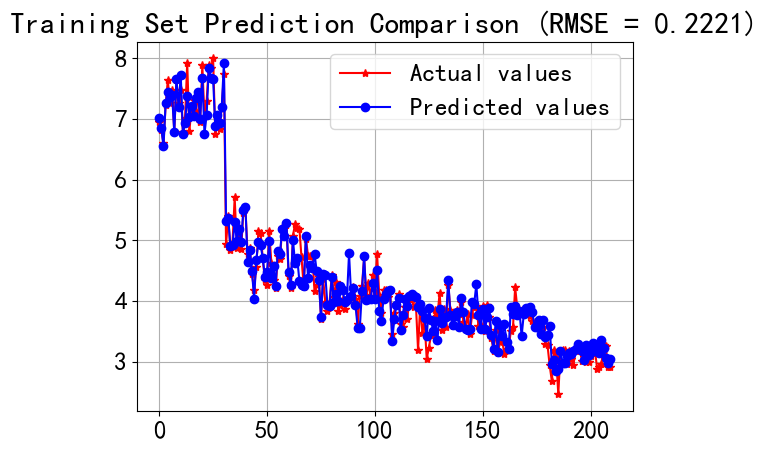

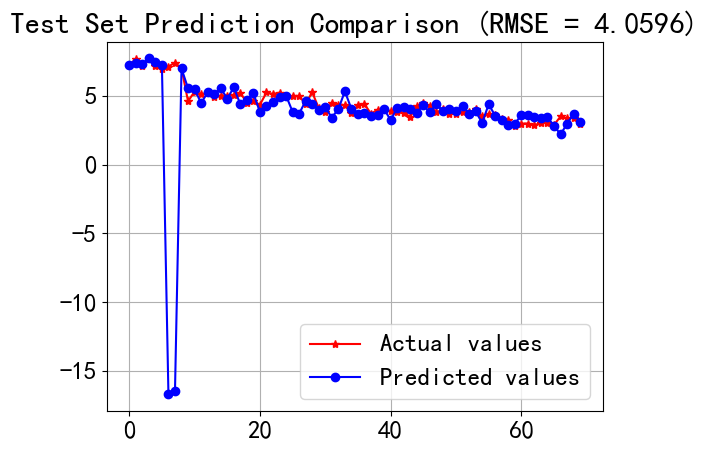

Training R²: 0.9725
Test R²: -9.3144
Training MAE: 0.1587
Test MAE: 1.0906
Training MBE: 0.0152
Test MBE: -0.7284


In [360]:
import matplotlib.pyplot as plt

# 设置字体为支持中文的字体，例如 SimHei
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Data inverse normalization
Y_train_pred = scaler_Y.inverse_transform(Y_train_pred.cpu().numpy().reshape(-1, 1)).flatten()
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred.cpu().numpy().reshape(-1, 1)).flatten()
Y_train_actual = scaler_Y.inverse_transform(Y_train_tensor.cpu().numpy().reshape(-1, 1)).flatten()
Y_test_actual = scaler_Y.inverse_transform(Y_test_tensor.cpu().numpy().reshape(-1, 1)).flatten()


# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(Y_train_actual, Y_train_pred))
test_rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_test_pred))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Plotting the prediction results
plt.figure()
plt.plot(Y_train_actual, 'r-*', label='Actual values')
plt.plot(Y_train_pred, 'b-o', label='Predicted values')
plt.title(f'Training Set Prediction Comparison (RMSE = {train_rmse:.4f})')
plt.legend()
plt.grid()

plt.figure()
plt.plot(Y_test_actual, 'r-*', label='Actual values')
plt.plot(Y_test_pred, 'b-o', label='Predicted values')
plt.title(f'Test Set Prediction Comparison (RMSE = {test_rmse:.4f})')
plt.legend()
plt.grid()

plt.show()

# R² coefficient calculation
train_r2 = 1 - np.sum((Y_train_actual - Y_train_pred) ** 2) / np.sum((Y_train_actual - np.mean(Y_train_actual)) ** 2)
test_r2 = 1 - np.sum((Y_test_actual - Y_test_pred) ** 2) / np.sum((Y_test_actual - np.mean(Y_test_actual)) ** 2)

print(f'Training R²: {train_r2:.4f}')
print(f'Test R²: {test_r2:.4f}')

# MAE and MBE calculation
train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
test_mae = mean_absolute_error(Y_test_actual, Y_test_pred)

train_mbe = np.mean(Y_train_pred - Y_train_actual)
test_mbe = np.mean(Y_test_pred - Y_test_actual)

print(f'Training MAE: {train_mae:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Training MBE: {train_mbe:.4f}')
print(f'Test MBE: {test_mbe:.4f}')


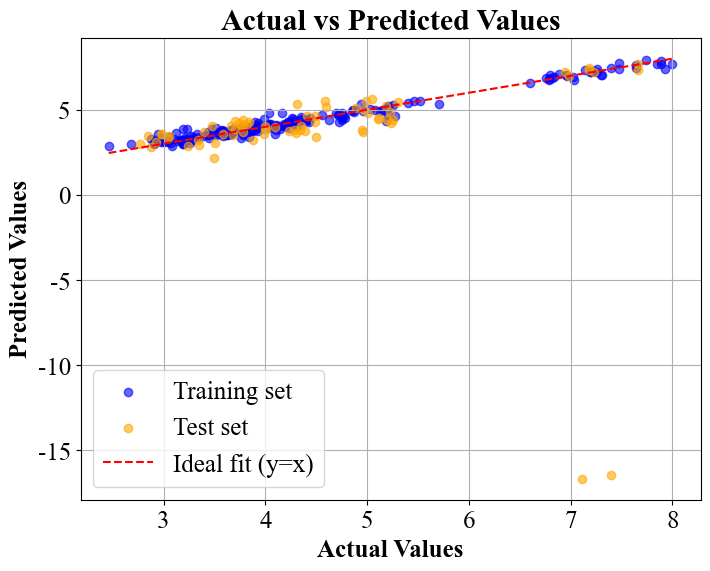

In [361]:
import matplotlib.pyplot as plt
# 调整字体
plt.rcParams['font.size'] = 18  # 设置全局字体大小
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 生成散点图比较真实值和预测值
plt.figure(figsize=(8, 6)) #尺寸  

# 绘制训练集散点图
plt.scatter(Y_train_actual, Y_train_pred, c='blue', label='Training set', alpha=0.6)
plt.scatter(Y_test_actual, Y_test_pred, c='orange', label='Test set', alpha=0.6)

# 绘制 y=x 参考线
max_val = max(Y_train_actual.max(), Y_test_actual.max())
min_val = min(Y_train_actual.min(), Y_test_actual.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal fit (y=x)')

# 设置图形标题和标签
plt.title('Actual vs Predicted Values', fontweight='bold')
plt.xlabel('Actual Values', fontweight='bold')
plt.ylabel('Predicted Values', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

